<a href="https://colab.research.google.com/github/Cpl-FilipePereira/Cpl-FilipePereira/blob/main/TPC_Modulo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to create a AI based model for melanoma screening

In [ ]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import zipfile
import random
import cv2

from google.colab import drive

#For results consistency
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

#Class 0 = benign; Class 1 = malignant
class_names = ["benign", "malignant"]

In [ ]:
def download_and_extract_dataset(): #Download zipfiles
    train_url = "http://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
    valid_url = "http://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
    test_url = "http://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"

    for i, download_link in enumerate ([valid_url, train_url, test_url]):
      temp_file = f"temp{i}.zip"

      data_dir = get_file(origin = download_link, fname = os.path.join(os.getcwd(), temp_file)) #descarregar ficheiros com TF

      print("Extraido...", download_link)
      with zipfile.ZipFile(data_dir, "r") as z:
        z.extractall("data")

      os.remove(temp_file)  #Apagar ficheiros temporários

download_and_extract_dataset()

864538487/864538487 [==============================] - 31s 0us/step
Extraido... http://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736557430/5736557430 [==============================] - 150s 0us/step
Extraido... http://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528640507/5528640507 [==============================] - 288s 0us/step
Extraido... http://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [ ]:
#Criação de ficheiros CSV para arquivo e tag de imagem
#label2int = dicionário classificador, tag para integer
#"nevus" & "seborrheic_keratosis" = 0 = Benign; "melanoma" = 1 = Malignant
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)

    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
      print("Reading", os.path.join(folder, label, "*"))
      for filepath in glob.glob(os.path.join(folder, label, "*")):
        df.loc[i] = [filepath, label2int[label]]
        i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

generate_csv("data/train", {"nevus":0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus":0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus":0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [ ]:
drive.mount("/content/drive", force_remount=True) #Guardar ficheiros no drive para facilidade de acesso; force_remount= para forçar nova montagem (não obrigatório)

Mounted at /content/drive


In [ ]:
#preparação do ficheiro .csv treino e validação
train_metadata = "train.csv"
valid_metadata = "valid.csv"

df_train = pd.read_csv(train_metadata)#criação dos DataFrame
df_valid = pd.read_csv(valid_metadata)

n_training_samples = len(df_train)
n_validation_samples = len(df_valid)

print("Number of training samples", len(df_train)) #Impressão do n de casos
print("Number of validation samples", len(df_valid))

#Criação de dataset com TensorFlow para alimentar o modelo
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples 2000
Number of validation samples 150


In [ ]:
df_train.head(5)#Visualizar dataframe dos 5 primeiros casos de treino


,Unnamed: 0,filepath,label
0,0,data/train/nevus/ISIC_0012228.jpg,0
1,1,data/train/nevus/ISIC_0000071.jpg,0
2,2,data/train/nevus/ISIC_0000186.jpg,0
3,3,data/train/nevus/ISIC_0010365.jpg,0
4,4,data/train/nevus/ISIC_0012230.jpg,0


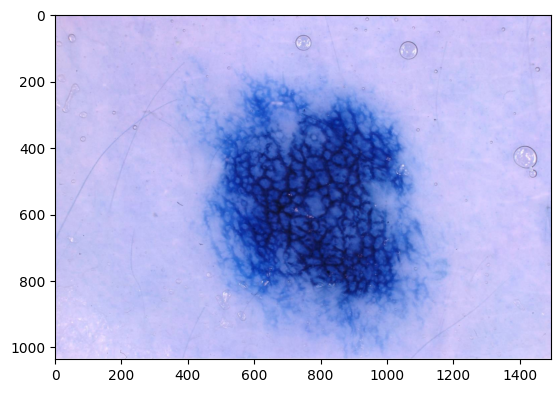

In [ ]:
plt.imshow(cv2.imread(df_train.filepath[48])) #Visualizar uma imagem especifica

In [ ]:
cv2.imread(df_train.filepath[48]).max() #identificação do máximo de brilho na imagem, sendo 255 o branco absoluto

255

In [ ]:
cv2.imread(df_train.filepath[48]).shape #Shape é um tuple com nº de linhas, nº de columas e nº de canais de cor

(1036, 1494, 3)

In [ ]:
#How many pixels are in a image?
pixel = 2848*4288
print("Nº pixeis na imagem:", pixel)

Nº pixeis na imagem: 12212224


##Pre-processing

In [ ]:
def decode_img(img): #transformar imagem em floats [0,1] com tamanho desejado
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [299,299])

def process_path(filepath, label): #carregar data como string
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

#usar função map para aplicar função a todas as imagens
train_ds = train_ds.map(process_path)
valid_ds = valid_ds.map(process_path)

In [ ]:
#Confirmação da execução das funções descritas
for image, label in train_ds.take(4):
    print("Image Shape", image.shape)
    print("Label", label.numpy())

Image Shape (299, 299, 3)
Label 0
Image Shape (299, 299, 3)
Label 0
Image Shape (299, 299, 3)
Label 0
Image Shape (299, 299, 3)
Label 0


##Data Visualization

In [ ]:
x = df_train["label"].value_counts().index #Contagem do nº de index
y = df_train["label"].value_counts() #contagem do nº de casos

data_train = go.Bar(x=x, y=y, marker = {"color": "green"}) #Usar gráficos interactivos
layout_train = go.Layout(title = "Label em Train", width=400, height=400)
fig_train = go.Figure (data = data_train, layout = layout_train)

fig_train.show()

In [ ]:
x = df_valid["label"].value_counts().index #Contagem do nº de index
y = df_valid["label"].value_counts() #contagem do nº de casos

data_valid = go.Bar(x=x, y=y, marker = {"color": "red"}) #Usar gráficos interactivos
layout_valid = go.Layout(title = "Label em Valid", width=400, height=400)
fig_valid = go.Figure (data = data_valid, layout = layout_valid)

fig_valid.show()

#Preparação e dos dados e Treino e Validação

In [ ]:
batch_size=50 #nº de exemplos a ser usados como treino
optimizer= "rmsprop" #tipo de ajuste ao weight

def preparar_training (ds, cache=True, batch_size=50, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size = shuffle_buffer_size)#Baralhar os exemplos para amostragem aleatoria
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)#prefetch permite ir buscar amostras enquanto faz treinamento
  return ds

#Ambos os dataset estão em memória temporaria (cache), baralhados (shuffle), repetidos, agrupados (batched) e precarregados
valid_ds = preparar_training(valid_ds, batch_size=batch_size, cache= "valid_cache_data")
train_ds = preparar_training(train_ds, batch_size=batch_size, cache= "train_cache_data")

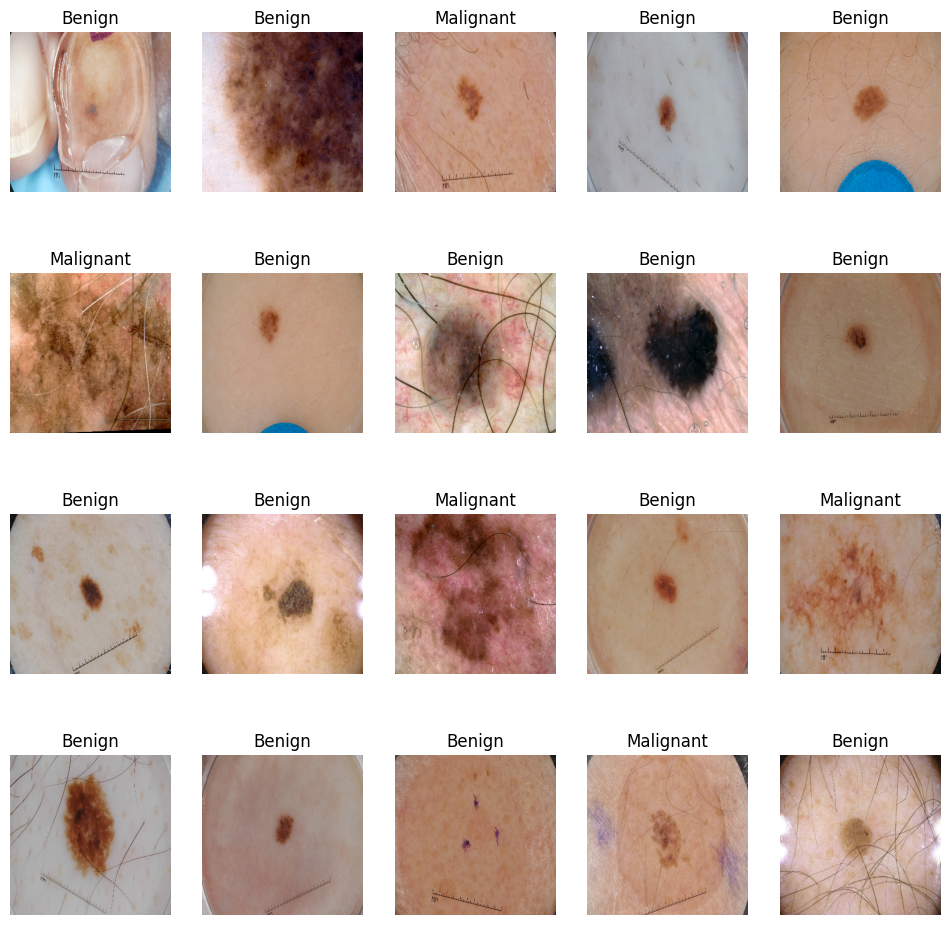

In [ ]:
batch = next(iter(valid_ds))
#Visualização
def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(20):
    ax = plt.subplot(4,5,n+1)
    plt.imshow(batch[0][n]) #Dentro do primeiro ([0]) lote de imagens(batch), plt mostra a imagem na posição [n]
    plt.title(class_names[batch[1][n].numpy()].title())
    plt.axis("off")

show_batch(batch)


##Construção do Modelo

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4" #importar pre-treinamento inceprion_v3

#criação do modelo "m"
m = tf.keras.Sequential([hub.KerasLayer(module_url, output_shape=[2048], trainable= False), #1ª camada sem correção após treino; cada entrada produzirá 2048 saídas
                         tf.keras.layers.Dense(1, activation= "sigmoid")]) #2ª camada com activação sigmóide. Densa significa que todos os perceptrões comunicam entre si

m.build([None, 299, 299, 3])

m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])#utilização do mesmo optimizer e função de perda "binary_crossentropy". Métrica usada vai ser accuracy

m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


##Model Training

In [ ]:
from keras.src.callbacks import EarlyStopping #Callback que para o treino do model quando a metrica deixa de melhorar, evitando o overfitting

model_name = f"benign-vs-malignant_{batch_size}_{optimizer}" #batizando o modelo

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name)) #Tensorboard é outro callback, este para visualização

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_best.hdf5", save_best_only=True, verbose=1) #Outro callback, salva o modelo com melhores weights e melhor performance.
#O verbose vai de 0 a 3, com incrementos dos niveis de informação apresentada durante o treinamento

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience=4)

#Model Training, outra maneira de dizer cerca de 7 minutos por epoch
history = m.fit(train_ds,
                validation_data = valid_ds,
                steps_per_epoch = n_training_samples//batch_size,
                validation_steps = n_validation_samples//batch_size,
                verbose = 1,
                epochs = 10,
                callbacks= [tensorboard, modelcheckpoint, earlystopping])

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8055 
Epoch 1: val_loss improved from inf to 0.56725, saving model to benign-vs-malignant_50_rmsprop_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



40/40 [==============================] - 521s 13s/step - loss: 0.4043 - accuracy: 0.8055 - val_loss: 0.5672 - val_accuracy: 0.7467
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8155 
Epoch 2: val_loss improved from 0.56725 to 0.45292, saving model to benign-vs-malignant_50_rmsprop_best.hdf5
40/40 [==============================] - 466s 12s/step - loss: 0.3924 - accuracy: 0.8155 - val_loss: 0.4529 - val_accuracy: 0.8000
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8325 
Epoch 3: val_loss improved from 0.45292 to 0.43087, saving model to benign-vs-malignant_50_rmsprop_best.hdf5
40/40 [==============================] - 468s 12s/step - loss: 0.3648 - accuracy: 0.8325 - val_loss: 0.4309 - val_accuracy: 0.8067
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8420 
Epoch 4: val_loss improved from 0.43087 to 0.42525, saving model to benign-vs-malignant_50_rmsprop_best.

##Avaliação do modelo

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename) #Carregar o dataset de teste
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def preparar_teste(ds, cache=True, shuffle_buffer_size=1000): #criar função de preparação para teste
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    return ds

test_ds = test_ds.map(process_path)
test_ds = preparar_teste(test_ds, cache="test-cached-data")


Number of testing samples: 600


In [ ]:
y_test = np.zeros((n_testing_samples))#cria um array com label vazio para o teste
X_test = np.zeros((n_testing_samples, 299, 299, 3)) #cria um array para arquivar imagens

for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
    X_test[i] = img
    y_test[i] = label.numpy()
#vai demorar 2 minutos
print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [ ]:
m.load_weights("benign-vs-malignant_50_rmsprop_best.hdf5")
#carregar o modelo

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=3)
#outro processo lento, outros 2 minutos

print("Loss:",loss)
print("Accuracy:", accuracy)

Evaluating the model...
Loss: 0.45219171047210693
Accuracy: 0.8016666769981384


In [ ]:
def get_predictions(threshold = None):
  y_pred = m.predict(X_test) #modelo vai prever probabilidade de ser classe 1(malignant)
  if not threshold:
    threshold = 0.5 #Classifica como malignant se probabilidade for >=50%
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    if y_pred[i][0] >= threshold: #Se resultado for 1, melanoma
      result[i] = 1 #tudo o resto é benigno
  return result

threshold = 0.2 # valores de 20% de certeza que se trata de malignant são classificadas de malignant, para ter mais margem

y_pred = get_predictions(threshold)

19/19 [==============================] - 127s 7s/step


##Confusion Matrix

[[0.49275362 0.50724638]
 [0.21367521 0.78632479]]


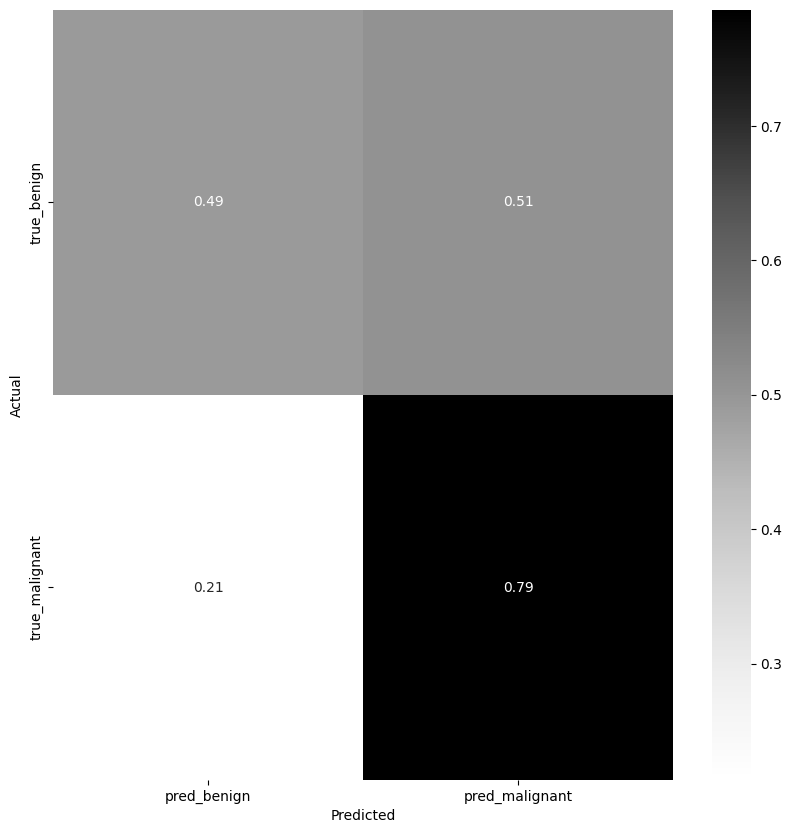

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  cmn = cmn.astype("float")/cmn.sum(axis=1)[:, np.newaxis]
  print(cmn)

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot = True, fmt = ".2f",
              xticklabels = [f"pred_{c}" for c in class_names],
              yticklabels = [f"true_{c}" for c in class_names],
              cmap = "Greys")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show

plot_confusion_matrix(y_test, y_pred)

In [ ]:
sensibilidade = sensitivity_score(y_test, y_pred)
especificidade = specificity_score(y_test, y_pred)

print("Melanoma sensibility, the ability of detecting true positives", sensibilidade.round(4))
print("Melanoma specificity, the ability of detecting true negatives", especificidade.round(4))


Melanoma sensibility, the ability of detecting true positives 0.7863
Melanoma specificity, the ability of detecting true negatives 0.4928


ROC AUC: 0.640


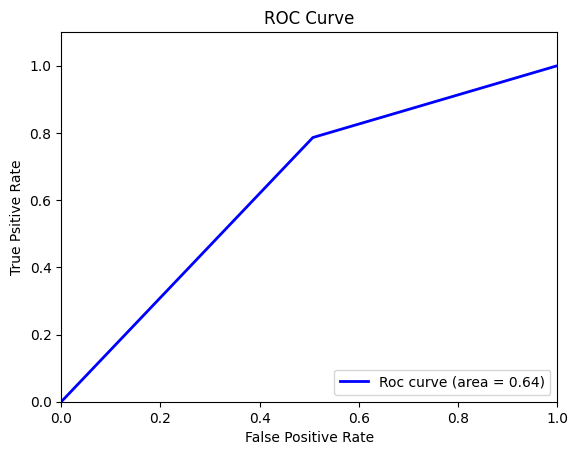

In [ ]:
def plot_roc_auc(y_true, y_pred):
  plt.figure()
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  print(f"ROC AUC: {roc_auc:.3f}")
  plt.plot(fpr, tpr, color ="blue", lw=2, label ="Roc curve (area = {f:.2f})".format(d=1, f=roc_auc))
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.1])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Psitive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

plot_roc_auc(y_test, y_pred)


##Elevando o Threshold para 75%

In [ ]:
def get_predictions_75(threshold = None):
  y_pred_75 = m.predict(X_test) #modelo vai prever probabilidade de ser classe 1(malignant)
  if not threshold:
    threshold = 0.5 #Classifica como malignant se probabilidade for >=50%
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    if y_pred_75[i][0] >= threshold: #Se resultado for 1, melanoma
      result[i] = 1 #tudo o resto é benigno
  return result

threshold = 0.75 # valores de 75% de certeza que se trata de malignant são classificadas de malignant, para ter maior especificidade

y_pred_75 = get_predictions_75(threshold)

19/19 [==============================] - 120s 6s/step


[[1. 0.]
 [1. 0.]]


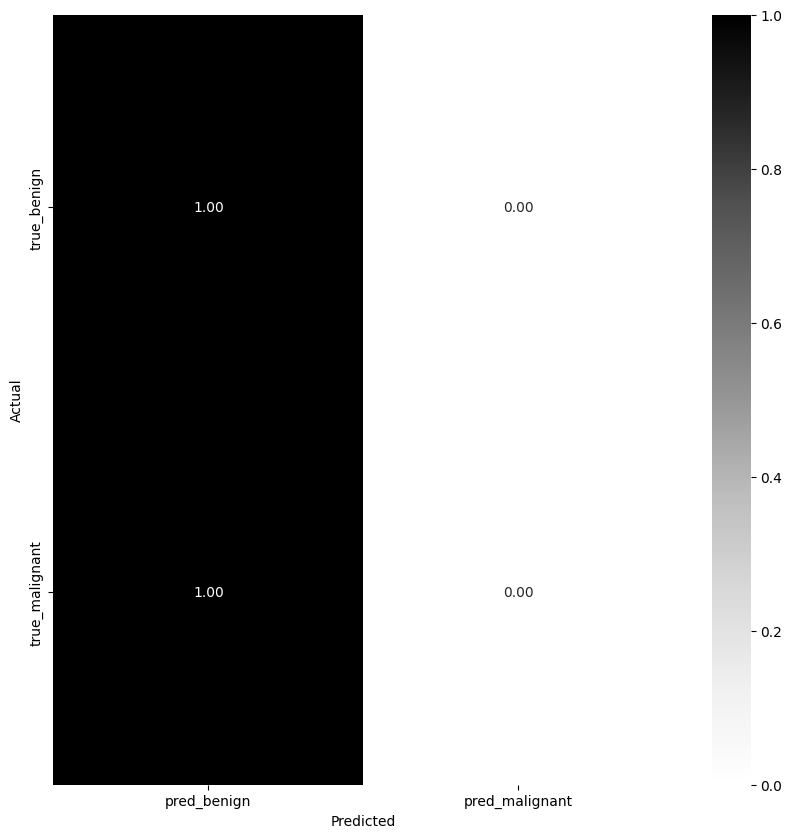

In [ ]:
def plot_confusion_matrix_75(y_test, y_pred_75):
  cmn_75 = confusion_matrix(y_test, y_pred_75)
  cmn_75 = cmn_75.astype("float")/cmn_75.sum(axis=1)[:, np.newaxis]
  print(cmn_75)

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn_75, annot = True, fmt = ".2f",
              xticklabels = [f"pred_{c}" for c in class_names],
              yticklabels = [f"true_{c}" for c in class_names],
              cmap = "Greys")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show

plot_confusion_matrix_75(y_test, y_pred_75)

In [ ]:
sensibilidade_75 = sensitivity_score(y_test, y_pred_75)
especificidade_75 = specificity_score(y_test, y_pred_75)

print("Melanoma sensibility, the ability of detecting true positives", sensibilidade_75.round(4))
print("Melanoma specificity, the ability of detecting true negatives", especificidade_75.round(4))

Melanoma sensibility, the ability of detecting true positives 0.0
Melanoma specificity, the ability of detecting true negatives 1.0


ROC AUC: 0.500


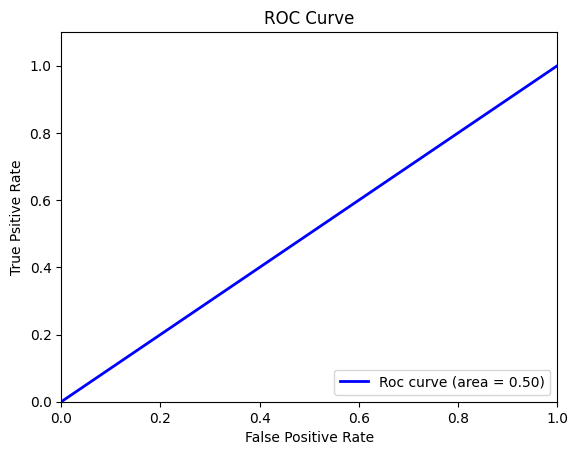

In [ ]:
def plot_roc_auc_75(y_true, y_pred_75):
  plt.figure()
  fpr, tpr, _ = roc_curve(y_true, y_pred_75)
  roc_auc = auc(fpr, tpr)
  print(f"ROC AUC 0.75: {roc_auc:.3f}")
  plt.plot(fpr, tpr, color ="blue", lw=2, label ="Roc curve (area = {f:.2f})".format(d=1, f=roc_auc))
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.1])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Psitive Rate")
  plt.title("ROC Curve 0.75")
  plt.legend(loc="lower right")
  plt.show()

plot_roc_auc(y_test, y_pred_75)